# CNN Activity

In [1]:
#%pip install torchvision torchsummary Pillow --quiet

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset

import torchvision
from torchvision import transforms, models
from torchvision.models import MobileNet_V2_Weights

from torchsummary import summary
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Dataset

In [4]:
class HandwrittenDigitsDataset(Dataset):
    """Loads digit images from a folder with subfolders 0-9."""

    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for label in range(10):
            folder = os.path.join(root_dir, str(label))
            if not os.path.isdir(folder):
                print(f"Warning: folder {folder} not found, skipping.")
                continue
            for fname in os.listdir(folder):
                if fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
                    self.samples.append((os.path.join(folder, fname), label))

        print(f"Loaded {len(self.samples)} images from {root_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("L")   # grayscale
        if self.transform:
            img = self.transform(img)
        return img, label

## Transforms & DataLoaders

In [5]:
# ── Paths ──────────────────────────────────────────────────────────────────────
OWN_DATA_DIR   = "LT3_digits/LT3_digits"       # our own dataset
# OTHER_DATA_DIR = "LTother_digits/LTother_digits"  # uncomment when received

IMAGE_SIZE = 32
BATCH_SIZE = 16

# Scratch model — 1 channel (grayscale)
transform_scratch = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Pretrained MobileNetV2 — 3 channels + ImageNet normalization
transform_pretrained = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load datasets
own_scratch    = HandwrittenDigitsDataset(OWN_DATA_DIR, transform=transform_scratch)
own_pretrained = HandwrittenDigitsDataset(OWN_DATA_DIR, transform=transform_pretrained)

# 80/20 train-val split
def make_split(dataset, val_ratio=0.2):
    val_size   = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

train_scratch,    val_scratch    = make_split(own_scratch)
train_pretrained, val_pretrained = make_split(own_pretrained)

train_loader_scratch    = DataLoader(train_scratch,    batch_size=BATCH_SIZE, shuffle=True)
val_loader_scratch      = DataLoader(val_scratch,      batch_size=BATCH_SIZE, shuffle=False)
train_loader_pretrained = DataLoader(train_pretrained, batch_size=BATCH_SIZE, shuffle=True)
val_loader_pretrained   = DataLoader(val_pretrained,   batch_size=BATCH_SIZE, shuffle=False)

# Sanity check
imgs, _ = next(iter(train_loader_scratch))
print(f"Scratch  batch shape : {imgs.shape}")    # [16, 1, 32, 32]
imgs, _ = next(iter(train_loader_pretrained))
print(f"Pretrain batch shape : {imgs.shape}")    # [16, 3, 32, 32]

Loaded 100 images from LT3_digits/LT3_digits
Loaded 100 images from LT3_digits/LT3_digits
Scratch  batch shape : torch.Size([16, 1, 32, 32])
Pretrain batch shape : torch.Size([16, 3, 32, 32])


### Quick peek at the data

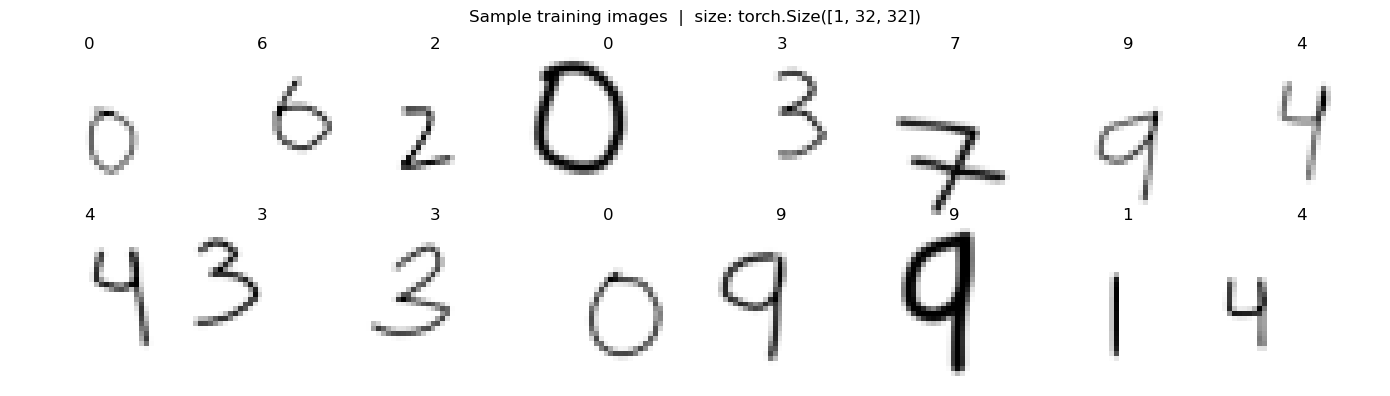

In [6]:
images, labels = next(iter(train_loader_scratch))

fig, axes = plt.subplots(2, 8, figsize=(14, 4))
for i in range(16):
    ax = axes[i // 8][i % 8]
    ax.imshow(images[i].squeeze(), cmap="gray")
    ax.set_title(labels[i].item())
    ax.axis("off")
plt.suptitle(f"Sample training images  |  size: {images[0].size()}")
plt.tight_layout()
plt.show()

## CNN from Scratch

In [7]:
import torch
import torch.nn as nn


class DigitCNN(nn.Module):
    """
    CNN optimized for extremely small datasets (≈100 images).
    """

    def __init__(self, n_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            # -------- Block 1 --------
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),

            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),

            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),

            # -------- Block 2 --------
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),

            nn.Dropout2d(0.3),
            nn.MaxPool2d(2),

            # -------- Block 3 --------
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),

            nn.Dropout2d(0.4),
            nn.MaxPool2d(2),
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(128, n_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="leaky_relu")
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Fine-tuned MobileNetV2

In [8]:
class DigitPretrainedCNN(nn.Module):
    """MobileNetV2 fine-tuned for 32x32 digit classification."""

    def __init__(self, n_classes=10):
        super().__init__()
        base = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

        # Freeze all layers first
        for param in base.parameters():
            param.requires_grad = False

        # Unfreeze last 3 feature blocks for fine-tuning
        for layer in list(base.features)[-3:]:
            for param in layer.parameters():
                param.requires_grad = True

        self.features = base.features
        self.pool     = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_classes),
        )

    def forward(self, X):
        x = self.features(X)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [9]:
# Model A summary
scratch_model = DigitCNN().to(device)
print("=== Model A: DigitCNN (Scratch) ===")
summary(scratch_model, (1, 32, 32))

=== Model A: DigitCNN (Scratch) ===
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         Dropout2d-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
        LeakyReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
   

In [10]:
# Model B summary
pretrained_model = DigitPretrainedCNN().to(device)
print("\n=== Model B: DigitPretrainedCNN (MobileNetV2) ===")
summary(pretrained_model, (3, 32, 32))


=== Model B: DigitPretrainedCNN (MobileNetV2) ===
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
             ReLU6-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
             ReLU6-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 16, 16, 16]             512
       BatchNorm2d-8           [-1, 16, 16, 16]              32
  InvertedResidual-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 96, 16, 16]           1,536
      BatchNorm2d-11           [-1, 96, 16, 16]             192
            ReLU6-12           [-1, 96, 16, 16]               0
           Conv2d-13             [-1, 96, 8, 8]     

## Training

The `train_model` function returns both loss and accuracy histories so we can monitor learning.

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=30):
    """Train model and return loss + accuracy histories."""

    train_losses, val_losses = [], []
    train_accs,   val_accs   = [], []

    n_train = len(train_loader)
    n_val   = len(val_loader)

    for epoch in range(epochs):
        # ── Training ──────────────────────────────────────────────────────────
        model.train()
        running_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            preds = model(X_batch)
            loss  = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct      += (preds.argmax(1) == y_batch).sum().item()
            total        += y_batch.size(0)

        train_losses.append(running_loss / n_train)
        train_accs.append(correct / total)

        # ── Validation ────────────────────────────────────────────────────────
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)

                preds     = model(X_val)
                val_loss += criterion(preds, y_val).item()
                val_correct += (preds.argmax(1) == y_val).sum().item()
                val_total   += y_val.size(0)

        val_losses.append(val_loss / n_val)
        val_accs.append(val_correct / val_total)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1:3d}/{epochs}]  "
                  f"Train loss: {train_losses[-1]:.4f}  acc: {train_accs[-1]:.4f}  |  "
                  f"Val loss: {val_losses[-1]:.4f}  acc: {val_accs[-1]:.4f}")

    return train_losses, val_losses, train_accs, val_accs

### Train CNN from Scratch

In [12]:
EPOCHS = 50
LR     = 0.001

scratch_model    = DigitCNN().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_scratch = optim.Adam(scratch_model.parameters(), lr=LR)

print("Training Model A — Scratch CNN")
scratch_train_loss, scratch_val_loss, scratch_train_acc, scratch_val_acc = train_model(
    scratch_model, train_loader_scratch, val_loader_scratch,
    criterion, optimizer_scratch, device, epochs=EPOCHS
)

Training Model A — Scratch CNN
Epoch [  5/50]  Train loss: 2.4833  acc: 0.1875  |  Val loss: 2.3488  acc: 0.3000
Epoch [ 10/50]  Train loss: 2.2992  acc: 0.2375  |  Val loss: 2.4966  acc: 0.0500
Epoch [ 15/50]  Train loss: 2.2157  acc: 0.2250  |  Val loss: 2.3605  acc: 0.1500
Epoch [ 20/50]  Train loss: 1.9849  acc: 0.3500  |  Val loss: 2.2856  acc: 0.1000
Epoch [ 25/50]  Train loss: 1.9889  acc: 0.2875  |  Val loss: 1.9646  acc: 0.4000
Epoch [ 30/50]  Train loss: 1.6395  acc: 0.4875  |  Val loss: 1.8023  acc: 0.4000
Epoch [ 35/50]  Train loss: 1.4578  acc: 0.6250  |  Val loss: 1.6205  acc: 0.4000
Epoch [ 40/50]  Train loss: 1.4550  acc: 0.5625  |  Val loss: 1.5717  acc: 0.5000
Epoch [ 45/50]  Train loss: 1.2368  acc: 0.6750  |  Val loss: 1.4464  acc: 0.5000
Epoch [ 50/50]  Train loss: 1.1609  acc: 0.7250  |  Val loss: 1.2402  acc: 0.6500



Epoch [  5/30]  Train loss: 2.1610  acc: 0.1875  |  Val loss: 2.2577  acc: 0.1500
Epoch [ 10/30]  Train loss: 1.9952  acc: 0.2375  |  Val loss: 2.1088  acc: 0.1500
Epoch [ 15/30]  Train loss: 1.7584  acc: 0.3625  |  Val loss: 1.6732  acc: 0.4500
Epoch [ 20/30]  Train loss: 1.4266  acc: 0.5000  |  Val loss: 1.5572  acc: 0.4000
Epoch [ 25/30]  Train loss: 1.1581  acc: 0.6250  |  Val loss: 1.4542  acc: 0.2000
Epoch [ 30/30]  Train loss: 0.9864  acc: 0.7625  |  Val loss: 0.9974  acc: 0.6500


### Train MobileNetV2

In [13]:
pretrained_model       = DigitPretrainedCNN().to(device)
optimizer_pretrained    = optim.Adam(pretrained_model.parameters(), lr=LR)

print("Training Model B — Fine-tuned MobileNetV2")
pretrained_train_loss, pretrained_val_loss, pretrained_train_acc, pretrained_val_acc = train_model(
    pretrained_model, train_loader_pretrained, val_loader_pretrained,
    criterion, optimizer_pretrained, device, epochs=EPOCHS
)

Training Model B — Fine-tuned MobileNetV2
Epoch [  5/50]  Train loss: 1.8179  acc: 0.5000  |  Val loss: 2.5177  acc: 0.1000
Epoch [ 10/50]  Train loss: 1.3868  acc: 0.7125  |  Val loss: 2.2070  acc: 0.2500
Epoch [ 15/50]  Train loss: 1.0924  acc: 0.7875  |  Val loss: 2.4973  acc: 0.1500
Epoch [ 20/50]  Train loss: 1.0326  acc: 0.8125  |  Val loss: 2.1969  acc: 0.3000
Epoch [ 25/50]  Train loss: 0.8691  acc: 0.8875  |  Val loss: 1.9692  acc: 0.4000
Epoch [ 30/50]  Train loss: 0.9423  acc: 0.8250  |  Val loss: 2.0469  acc: 0.3500
Epoch [ 35/50]  Train loss: 0.8476  acc: 0.9000  |  Val loss: 2.3537  acc: 0.3500
Epoch [ 40/50]  Train loss: 0.8888  acc: 0.9125  |  Val loss: 2.0543  acc: 0.4000
Epoch [ 45/50]  Train loss: 0.8714  acc: 0.8875  |  Val loss: 2.2226  acc: 0.3000
Epoch [ 50/50]  Train loss: 0.8734  acc: 0.9000  |  Val loss: 1.8888  acc: 0.3500


## Training Curves

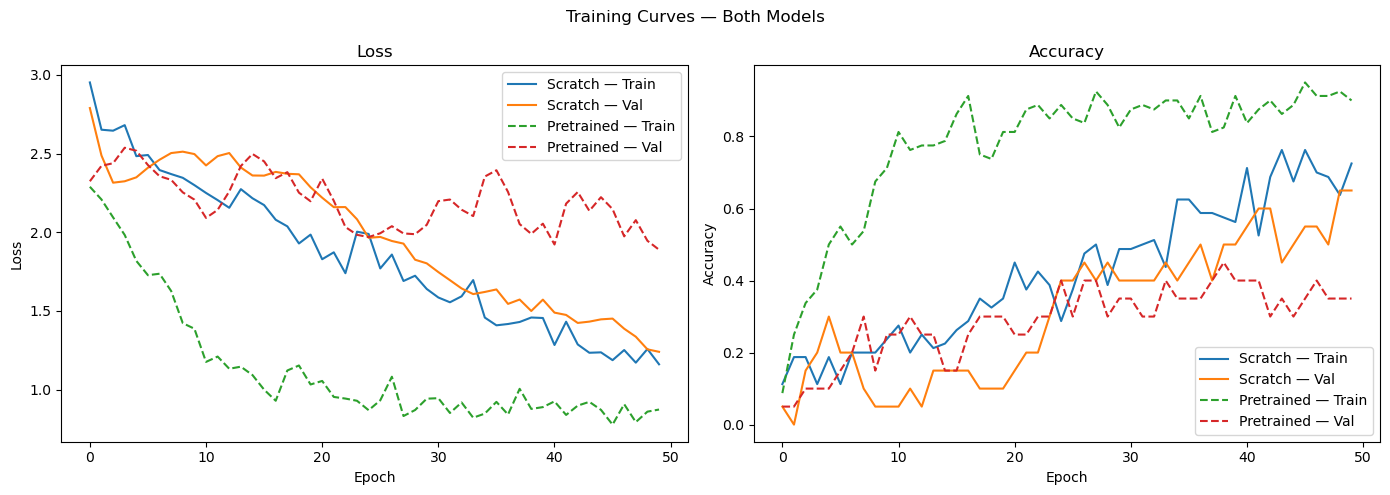

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(scratch_train_loss,    label="Scratch — Train")
axes[0].plot(scratch_val_loss,      label="Scratch — Val")
axes[0].plot(pretrained_train_loss, label="Pretrained — Train", linestyle="--")
axes[0].plot(pretrained_val_loss,   label="Pretrained — Val",   linestyle="--")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Accuracy curves
axes[1].plot(scratch_train_acc,    label="Scratch — Train")
axes[1].plot(scratch_val_acc,      label="Scratch — Val")
axes[1].plot(pretrained_train_acc, label="Pretrained — Train", linestyle="--")
axes[1].plot(pretrained_val_acc,   label="Pretrained — Val",   linestyle="--")
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.suptitle("Training Curves — Both Models")
plt.tight_layout()
plt.show()

## Evaluation

`evaluate_model` prints a classification report, plots a confusion matrix, and shows a grid of predictions.

In [15]:
def evaluate_model(model, loader, dataset_name, model_name, device):
    """Evaluate model: classification report + confusion matrix + prediction grid."""

    model.eval()
    all_preds, all_labels, all_images = [], [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            preds  = model(images).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_images.append(images.cpu())

    all_images = torch.cat(all_images)

    print(f"\n{'='*60}")
    print(f"  {model_name}  |  Dataset: {dataset_name}")
    print(f"{'='*60}")
    print(classification_report(all_labels, all_preds,
                             target_names=[str(i) for i in range(10)],
                             labels=list(range(10)),
                             zero_division=0))
    
    # ── Confusion matrix ──────────────────────────────────────────────────────
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=range(10), yticklabels=range(10))
    plt.title(f"Confusion Matrix — {model_name} on {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # ── Prediction grid ───────────────────────────────────────────────────────
    show_batch(all_images, all_labels, all_preds, n=16,
               title=f"{model_name} on {dataset_name}")

    acc = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    return acc


def show_batch(images, labels, preds, n=16, title=""):
    """Display a grid of images with true and predicted labels."""
    plt.figure(figsize=(14, 8))
    for i in range(min(n, len(images))):
        plt.subplot(4, 4, i + 1)
        img = images[i].squeeze()
        # Undo normalization for display — works for both 1-ch and 3-ch
        if img.ndim == 3:
            img = img.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            plt.imshow(img)
        else:
            img = img.numpy() * 0.5 + 0.5   # undo [-1,1] norm
            plt.imshow(img, cmap="gray")
        color = "green" if preds[i] == labels[i] else "red"
        plt.title(f"T:{labels[i]} P:{preds[i]}", color=color, fontsize=9)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

### Evaluate on Our Own Dataset (Validation Split)


  Scratch CNN  |  Dataset: LT3 (ours)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2
           4       0.67      1.00      0.80         2
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         4
           7       0.67      1.00      0.80         2
           8       0.00      0.00      0.00         1
           9       1.00      0.75      0.86         4

    accuracy                           0.65        20
   macro avg       0.58      0.64      0.59        20
weighted avg       0.63      0.65      0.62        20



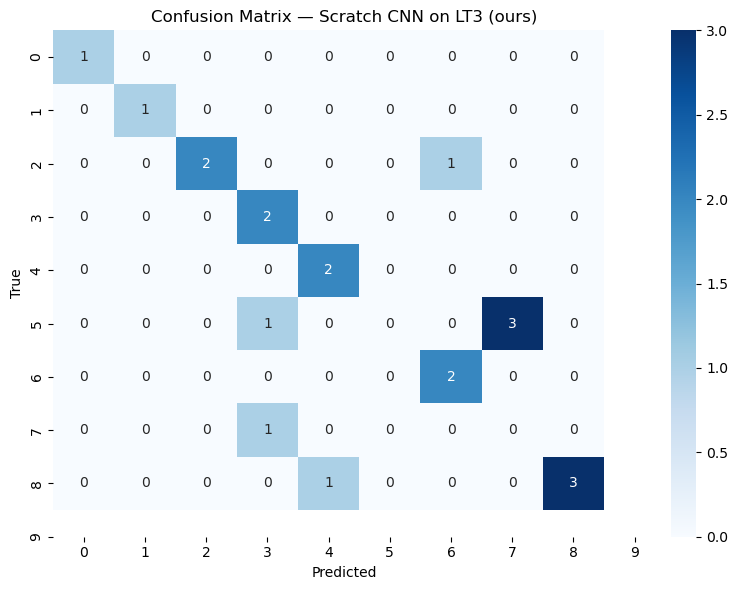

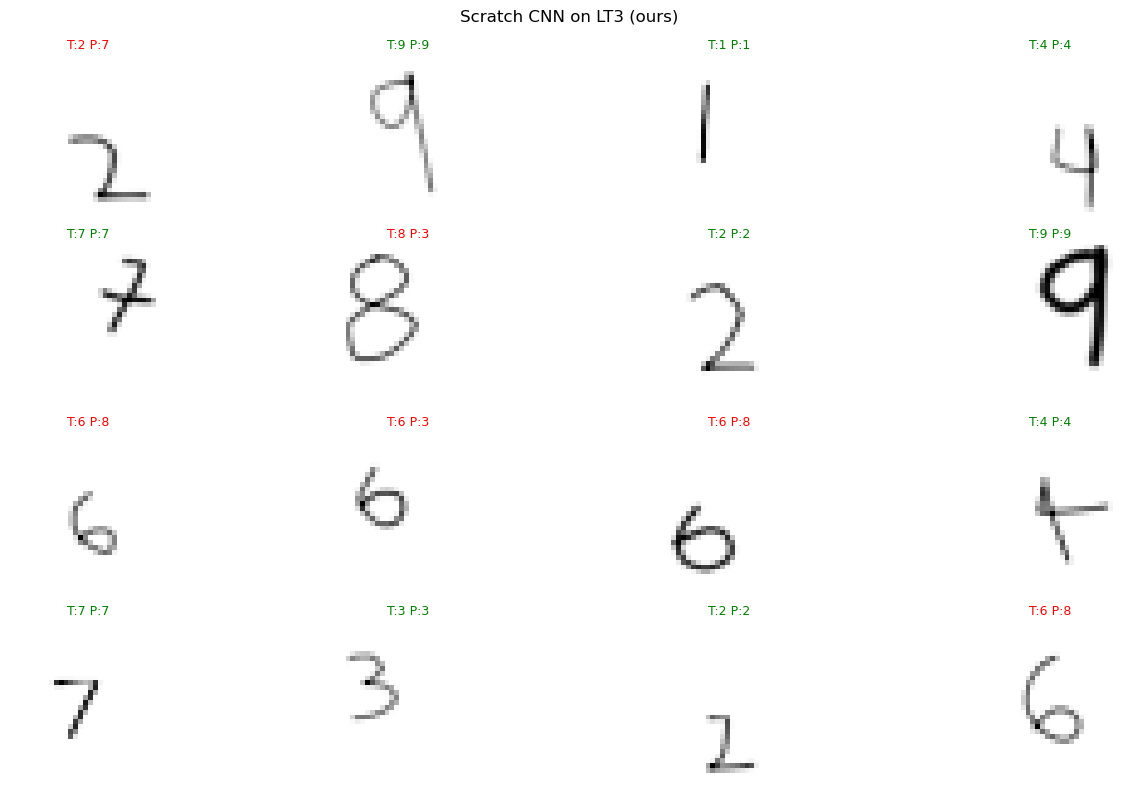


  MobileNetV2  |  Dataset: LT3 (ours)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67         2
           2       0.40      1.00      0.57         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.50      0.50      0.50         2
           6       0.50      1.00      0.67         1
           7       0.00      0.00      0.00         4
           8       0.25      1.00      0.40         1
           9       0.33      0.25      0.29         4

    accuracy                           0.35        20
   macro avg       0.30      0.42      0.31        20
weighted avg       0.29      0.35      0.28        20



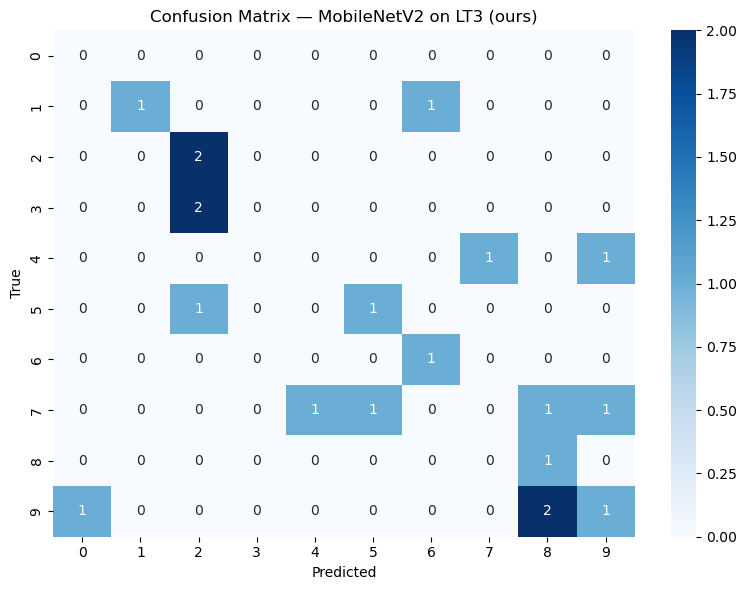

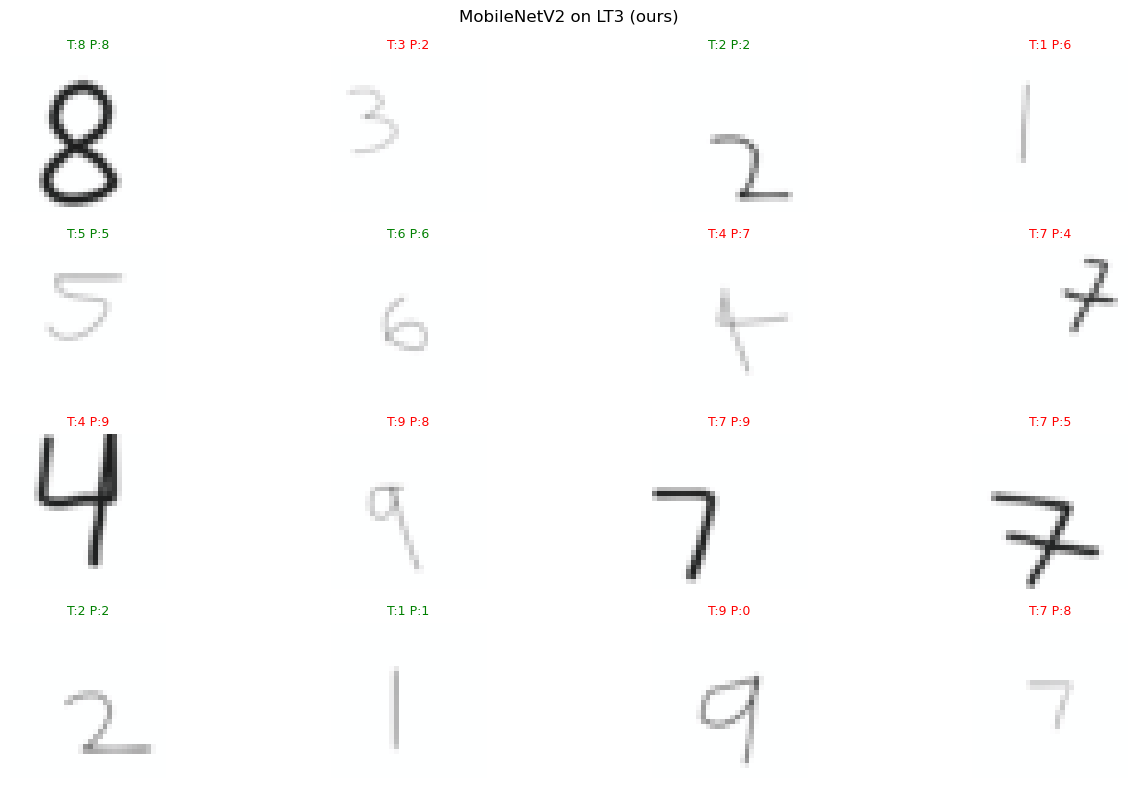

In [16]:
acc_scratch_own = evaluate_model(
    scratch_model, val_loader_scratch,
    dataset_name="LT3 (ours)", model_name="Scratch CNN", device=device
)

acc_pretrained_own = evaluate_model(
    pretrained_model, val_loader_pretrained,
    dataset_name="LT3 (ours)", model_name="MobileNetV2", device=device
)

## Other LT dataset test

Run this block after receiving the other team's dataset. Set `OTHER_DATA_DIR` to the correct path, then run.

In [ ]:
# ── Uncomment and update this path when you have the other team's ZIP ──────────
# OTHER_DATA_DIR = "LTother_digits/LTother_digits"

# other_scratch    = HandwrittenDigitsDataset(OTHER_DATA_DIR, transform=transform_scratch)
# other_pretrained = HandwrittenDigitsDataset(OTHER_DATA_DIR, transform=transform_pretrained)

# other_loader_scratch    = DataLoader(other_scratch,    batch_size=BATCH_SIZE, shuffle=False)
# other_loader_pretrained = DataLoader(other_pretrained, batch_size=BATCH_SIZE, shuffle=False)

# acc_scratch_other = evaluate_model(
#     scratch_model, other_loader_scratch,
#     dataset_name="Other Team", model_name="Scratch CNN", device=device
# )

# acc_pretrained_other = evaluate_model(
#     pretrained_model, other_loader_pretrained,
#     dataset_name="Other Team", model_name="MobileNetV2", device=device
# )

## Summary

In [ ]:
print("\n" + "="*55)
print(f"{'Model':<25} {'Dataset':<20} {'Val Acc':>8}")
print("-"*55)
print(f"{'Scratch CNN':<25} {'LT3 (ours)':<20} {acc_scratch_own*100:>7.1f}%")
print(f"{'MobileNetV2':<25} {'LT3 (ours)':<20} {acc_pretrained_own*100:>7.1f}%")
# Uncomment after running block 8:
# print(f"{'Scratch CNN':<25} {'Other Team':<20} {acc_scratch_other*100:>7.1f}%")
# print(f"{'MobileNetV2':<25} {'Other Team':<20} {acc_pretrained_other*100:>7.1f}%")
print("="*55)